# NLP Final Project: Predicting the Best Answer From Online Forum Questions

### *Group 5: Amélie Pingeot, Youssef Jachttar, Qinjiong Zeng & Thomas Vermaelen*

Based on a dataset of online forum questions that include answers, comments and other variables, we will attempt to build the optimal model that can predict whether an answer to a question was considered as the "Best Answer" according to users.  

In [ ]:
import os
import pandas as pd
from nltk.tokenize import TweetTokenizer,word_tokenize
import re
from bs4 import BeautifulSoup
import random
from random import sample
from gensim.models.word2vec import Word2Vec
import nltk
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import warnings
import pickle
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## I. Convert Provided File Into Readable CSV File

In [ ]:
os.chdir("/Users/thomasvermaelen/Documents/ESCP/NLP/Final Project")
txt_path = "./export-forums_en.csv"
entity_path = "./export-forums_en.pickle"
csv_path = "./export-forums_en.format.csv"
data_path = "./"

def format_entities():
    '''
    Read the raw data, format the list of entities, serialize them.
    '''

    def build_entities(txt_path, max_entities=None):
        '''
        Return a list of structured entities from raw txt file.
        '''
        # Read text file.
        with open(txt_path, 'r', encoding='utf8') as f:
            # Entities and current entity.
            entities, entity = [], {}
            # Entity values might be split over lines
            field_counter = 0
            # Process lines
            for line in f:
                # Prepare line
                line = line.replace("\\N", '"unkwown"')
                # Char start for extracted value.
                char_start = 1
                # Find values separators
                field_index = [m.start() for m in re.finditer('","', line)]
                # Browse value separators.
                for index in field_index:
                    # Extract in between value.
                    value = line[char_start:index]
                    # Update start index.
                    char_start = index + 3
                    # Update field counter.
                    field_counter += 1
                    # Update entity value.
                    try:
                        entity[field_names[field_counter-1]] += value
                    except KeyError:
                        entity[field_names[field_counter-1]] = value
                    except IndexError:
                        entity = {}
                        field_counter = 0
                # Content string is split.
                if field_counter == 7 and len(field_index) > 0:
                    entity[field_names[7]] = line[field_index[-1]:]
                    continue
                # Next content string.
                if field_counter == 7 and len(field_index) == 0:
                    entity[field_names[7]] += line
                    continue
                # Next entity.
                if len(entity) == 17:
                    field_counter = 0
                    entities.append(entity)
                    entity = {}
                    if max_entities is not None:
                        if len(entities) > max_entities:
                            return entities
        return entities

    # Write entities on disk.
    with open(entity_path, 'wb') as f:
        pickle.dump(build_entities(txt_path=txt_path, max_entities=None), f)


def entities_to_csv():
    '''
    Format entities to csv.
    '''
    with open(entity_path, 'rb') as obj:
        entities = pickle.load(obj)
    x = pd.DataFrame(entities)
    x.to_csv(csv_path)
    
format_entities()
entities_to_csv()

## II. Data Preparation

In [2]:
os.chdir("/Users/thomasvermaelen/Documents/ESCP/NLP/Final Project")
data = pd.read_csv("export-forums_en.format.csv", error_bad_lines= False) 
data = data.drop(columns=["Unnamed: 0"])

# sample 100,000 questions/topic_ids
ids = data[data.type =="Q"].iloc[:,[0,3]].copy()
random.seed(123)
samp_ind = sample(list(ids.id), 100000)
ids_samp = ids[ids.id.isin(samp_ind)]
samp = data[data.topic_id.isin(ids_samp.topic_id)].copy()
del data
samp.loc[samp.country=="unkwown", "country"]="unknown"
samp.content = samp.content.astype(str)
samp.head()

,id,type,is_best_answer,topic_id,parent_id,votes,title,content,member,category,state,is_solved,num_answers,country,date,last_answer_date,author_crc
185,5,Q,0,5,0,0,Trojan help,""",""Hello,\n\\nbr>I have a Trojan on my compute...",0,7,1,0,4,FR,1199900308,1208967475,2355851921
186,14,A,0,5,5,1,Trojan help,First problem is having Norton. This program d...,0,7,1,0,4,FR,1199952649,1208967475,1932528411
187,169,A,0,5,5,0,Trojan help,""",""hi there, \n\\n<br>\n\\n<br>please download...",2,7,1,0,4,FI,1201275303,1208967475,1113244950
188,4532,A,0,5,5,0,Trojan help,""",""HI I MOHAMED FROM ALEX I HAVE SOME PR...",0,7,1,0,4,unknown,1207942020,1208967475,1957797043
189,5318,A,1,5,5,2,Trojan help,"hey i had trojan on my pc , my friend told me ...",2,7,1,0,4,unknown,1208967475,1208967475,2126777814


In [3]:
#  clean, tokenize, stem
def clean_content(text):
    cleantext = text.lower()
    cleantext = BeautifulSoup(cleantext, "lxml").text    
    cleantext = cleantext.replace("\n"," ")
    cleantext = cleantext.replace(".", " ")
    cleantext= re.sub('[!"#%\'()*+,./:;<=>?@\[\]^-_`{|}~’”“′‘\\\]',' ', cleantext)
    cleantext = re.sub(" br ", " ", cleantext)
    return cleantext
samp.content = [clean_content(text) for text in samp.content]
tokenizer = TweetTokenizer() 
samp["content_tok"] =samp.content.apply(tokenizer.tokenize)
stop_words = nltk.corpus.stopwords.words('english')
samp['content_tok'] = samp["content_tok"].apply(lambda x: [word for word in x if word not in stop_words])
stemmer = PorterStemmer()
samp["content_tok"]=[[stemmer.stem(word) for word in word_vec] for word_vec in samp.content_tok]
samp.content_tok.head()

185    [hello, trojan, comput, norton, remov, wonder,...
186    [first, problem, norton, program, help, preven...
187    [hi, pleas, download, hijack, post, log, forum...
188    [hi, moham, alex, proplem, comput, becus, viru...
189    [hey, trojan, pc, friend, told, use, avira, an...
Name: content_tok, dtype: object

In [4]:
# merge countries that don't appear often into one class
from collections import Counter
country_counter = Counter(samp.country)
freq= list(country_counter.values())
countries = list(country_counter.keys())
indices = [x[0] for x in enumerate(freq) if x[1]/samp.shape[0] < 0.01]
countries_to_merge = [countries[i] for i in indices]
samp.loc[samp.country.isin(countries_to_merge), "country"]="other"

In [5]:
# create table of answers
answers = samp[samp.type =="A"].copy()
answers.index= range(answers.shape[0])
answers["question_tok"] = None
answers["comment_tok"] = None
answers["n_comments"] = None
# for each answer get its question and comment tokens, and number of comments
for i in range(answers.shape[0]):
    answers.at[i, "question_tok"] = samp.loc[samp.id == answers.loc[i,"parent_id"], "content_tok"].iloc[0]
    comments = samp[samp.parent_id == answers.loc[i,"id"]]
    answers.loc[i, "n_comments"] = int(comments.shape[0])
    answers.at[i, "comment_tok"] = list(comments.content_tok)
answers.head()

,id,type,is_best_answer,topic_id,parent_id,votes,title,content,member,category,...,is_solved,num_answers,country,date,last_answer_date,author_crc,content_tok,question_tok,comment_tok,n_comments
0,14,A,0,5,5,1,Trojan help,first problem is having norton this program d...,0,7,...,0,4,FR,1199952649,1208967475,1932528411,"[first, problem, norton, program, help, preven...","[hello, trojan, comput, norton, remov, wonder,...",[],0
1,169,A,0,5,5,0,Trojan help,hi there please download hijack this...,2,7,...,0,4,other,1201275303,1208967475,1113244950,"[hi, pleas, download, hijack, post, log, forum...","[hello, trojan, comput, norton, remov, wonder,...",[],0
2,4532,A,0,5,5,0,Trojan help,hi i mohamed from alex i have some pr...,0,7,...,0,4,unknown,1207942020,1208967475,1957797043,"[hi, moham, alex, proplem, comput, becus, viru...","[hello, trojan, comput, norton, remov, wonder,...",[],0
3,5318,A,1,5,5,2,Trojan help,hey i had trojan on my pc my friend told me ...,2,7,...,0,4,unknown,1208967475,1208967475,2126777814,"[hey, trojan, pc, friend, told, use, avira, an...","[hello, trojan, comput, norton, remov, wonder,...",[],0
4,25,A,0,8,8,0,Modem problem,sounds like a driver problem does he know wha...,0,5,...,0,2,FR,1200071299,1200071427,2156482720,"[sound, like, driver, problem, know, modem, br...","[friend, mine, comput, window, xp, profession,...",[],0


## III. Modeling 

In [6]:
#  train/test split
X = answers.drop(columns=["is_best_answer"])
y = answers.is_best_answer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

   ### A) Word2Vec 

In [7]:
#  Perform Word2Vec on answers, questions and comments
X_train_tokens = pd.concat([X_train.content_tok, X_train.question_tok])
emb_size =128
model_w2v = Word2Vec(size=emb_size, min_count=5)
model_w2v.build_vocab(X_train_tokens) 
def build_word2vec_from_text(model_w2v, sentence, emb_size):
    emb_vec = np.zeros(emb_size).reshape((1, emb_size))
    count = 0.
    for word in sentence:
        try:
            emb_vec += model_w2v[word].reshape((1, emb_size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        emb_vec /= count
    return emb_vec
X_train_answer_vec = pd.DataFrame(np.concatenate([build_word2vec_from_text(model_w2v, d, emb_size) for d in X_train.content_tok], axis=0))
X_train_question_vec= pd.DataFrame(np.concatenate([build_word2vec_from_text(model_w2v, d, emb_size) for d in X_train.question_tok], axis=0))
X_test_answer_vec = pd.DataFrame(np.concatenate([build_word2vec_from_text(model_w2v, d, emb_size) for d in X_test.content_tok], axis=0))
X_test_question_vec = pd.DataFrame(np.concatenate([build_word2vec_from_text(model_w2v, d, emb_size) for d in X_test.question_tok], axis=0))

#  Word2Vec for comments
def comments_word2vec(x):
    vec = [[build_word2vec_from_text(model_w2v, d, emb_size) for d in el]for el in x.comment_tok]
    vec = [sum(item)/len(item) if len(item)!=0 else item for item in vec]
    vec = [np.zeros(emb_size).reshape((1, emb_size)) if len(item)==0 else item for item in vec]
    vec = pd.DataFrame(np.concatenate(vec,axis=0))
    return vec

X_train_comment_vec = comments_word2vec(X_train)
X_test_comment_vec = comments_word2vec(X_test)

In [8]:
#  dummify categorical variable. remove useless ones too
def dummify(df):
    dummies= df.drop(columns= ["id","topic_id", "type", "parent_id", "title", "content", "category", "author_crc", "content_tok", "question_tok", "comment_tok"])
    dummies.member = dummies.member.astype(str)
    dummies.state = dummies.state.astype(str)
    dummies.is_solved = dummies.is_solved.astype(str)
    dummies.date = dummies.date.astype(int)
    dummies["year"] = [datetime.utcfromtimestamp(int(dummies.iloc[i,:]['date'])).strftime('%Y') for i in range(dummies.shape[0])]
    dummies["month"] = [datetime.utcfromtimestamp(int(dummies.iloc[i,:]['date'])).strftime('%m') for i in range(dummies.shape[0])]
    dummies["time_diff"] = dummies.last_answer_date - df.date
    dummies = dummies.drop(columns = ["date", "last_answer_date"])
    dummies = pd.get_dummies(dummies, columns = ["member"])
    dummies = pd.get_dummies(dummies, columns = ["state"])
    dummies = pd.get_dummies(dummies, columns = ["is_solved"])
    dummies = pd.get_dummies(dummies, columns = ["country"])
    dummies = pd.get_dummies(dummies, columns = ["year"])
    dummies = pd.get_dummies(dummies, columns = ["month"])
    dummies = dummies.drop(columns=["member_0", "state_0", "is_solved_0", "year_2008", "month_01","country_unknown"])
    return(dummies)
X_train = dummify(X_train)
X_test= dummify(X_test)
X_train.index = range(X_train.shape[0])
X_train= pd.concat([X_train,X_train_answer_vec, X_train_question_vec,X_train_comment_vec],axis=1)
X_test.index = range(X_test.shape[0])
X_test= pd.concat([X_test,X_test_answer_vec, X_test_question_vec,X_test_comment_vec],axis=1)


In [9]:
#  Scale
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(X_train)
X_train_scaled = scale.transform(X_train)
X_test_scaled = scale.transform(X_test)

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# function to plot roc and show auc for both train and test sets for a given model
def plot_roc(model, model_name):
    prob_train= model.predict_proba(X_train_scaled)[:,1]
    fpr_train, tpr_train, cutoffs = roc_curve(y_train, prob_train)
    
    prob_test= model.predict_proba(X_test_scaled)[:,1]
    fpr_test, tpr_test, cutoffs = roc_curve(y_test, prob_test)
    
    plt.title("ROC Curve for {} Model of Best Answer".format(model_name))
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    roc_train, = plt.plot(fpr_train, tpr_train, label ="AUC train: {:.2}".format(auc(fpr_train, tpr_train)), c= "blue")
    roc_test, = plt.plot(fpr_test, tpr_test, label ="AUC test: {:.2}".format(auc(fpr_test, tpr_test)), c= "orange")
    plt.legend(handles=[roc_train, roc_test])
    plt.show() 

### B) Logistic Regression

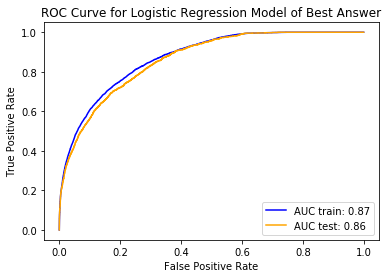

In [11]:
# LR with CV
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(penalty='l2', cv = 10, max_iter = 5000)
lr.fit(X_train_scaled, y_train)
plot_roc(lr, "Logistic Regression")

### C) Random Forest

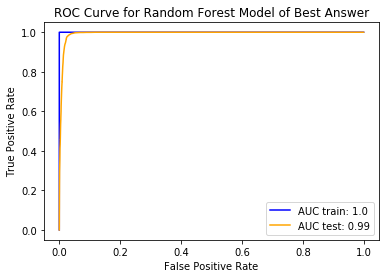

In [12]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
plot_roc(rf, "Random Forest")

### D) Random Forest vs. Logistic Regression

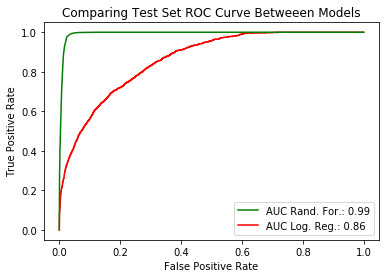

In [13]:
# Compare ROC between Random Forest and Logistic Regression
prob_lr= lr.predict_proba(X_test_scaled)[:,1]
fpr_lr, tpr_lr, cutoffs = roc_curve(y_test, prob_lr)  
prob_rf= rf.predict_proba(X_test_scaled)[:,1]
fpr_rf, tpr_rf, cutoffs = roc_curve(y_test, prob_rf)    
plt.title("Comparing Test Set ROC Curve Betweeen Models")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
roc_lr, = plt.plot(fpr_lr, tpr_lr, label ="AUC Log. Reg.: {:.2}".format(auc(fpr_lr, tpr_lr)), c= "red")
roc_rf, = plt.plot(fpr_rf, tpr_rf, label ="AUC Rand. For.: {:.2}".format(auc(fpr_rf, tpr_rf)), c= "green")
plt.legend(handles=[roc_rf, roc_lr])
plt.show()

Our final results reveal that Random Forest outperforms Logistic Regression in predicting the best answer, where AUC of RF = 0.99 and AUC of LR = 0.86 for the testing set. 